In [1]:
import argparse
import logging
import math
import os
import pickle
import random
import time
import logging
from tqdm import tqdm

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

from model.models import STGCNChebGraphConv, STGCNGraphConv
from utils import calc_gso, calc_chebynet_gso, evaluate_metric, evaluate_model, EarlyStopping, set_env, data_transform

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


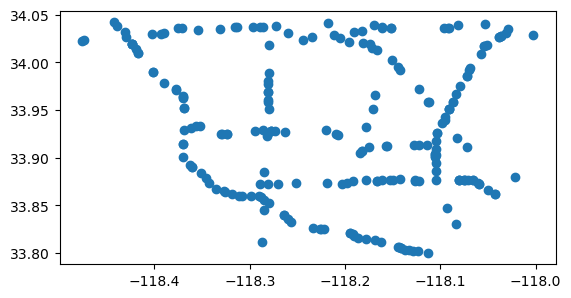

In [2]:
# Load data
adj_mx = pd.read_csv('data/PeMSD7_W_228.csv', header=None)
adj_mx = np.array(adj_mx)

data = pd.read_csv('data/PeMSD7_V_228.csv', header=None)
data = np.array(data)

info = pd.read_csv('data/PeMSD7_M_Station_Info.csv', index_col=0)
info = gpd.GeoDataFrame(info, geometry=gpd.points_from_xy(info.Longitude, info.Latitude))


info.plot()
plt.show()

In [3]:
def get_parameters(args=None):
    parser = argparse.ArgumentParser(description='STGCN')
    parser.add_argument('--enable_cuda', type=bool, default=True, help='enable CUDA, default as True')
    parser.add_argument('--seed', type=int, default=42, help='set the random seed for stabilizing experiment results')
    parser.add_argument('--n_his', type=int, default=12, help='number of time intervals in the past')
    parser.add_argument('--n_pred', type=int, default=3, help='the number of time interval for predcition, default as 3')
    parser.add_argument('--time_intvl', type=int, default=5, help='time interval, default as 5')
    parser.add_argument('--Kt', type=int, default=3, help='kernel size of temporal convolution')
    parser.add_argument('--stblock_num', type=int, default=2, help='number of ST-Conv blocks')
    parser.add_argument('--act_func', type=str, default='glu', choices=['glu', 'gtu'])
    parser.add_argument('--Ks', type=int, default=3, choices=[3, 2], help='kernel size of spatial convolution')
    parser.add_argument('--graph_conv_type', type=str, default='cheb_graph_conv', choices=['cheb_graph_conv', 'graph_conv'])
    parser.add_argument('--gso_type', type=str, default='sym_norm_lap', choices=['sym_norm_lap', 'rw_norm_lap', 'sym_renorm_adj', 'rw_renorm_adj'])
    parser.add_argument('--enable_bias', type=bool, default=True, help='default as True')
    parser.add_argument('--droprate', type=float, default=0.5)
    parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
    parser.add_argument('--weight_decay_rate', type=float, default=0.0005, help='weight decay (L2 penalty)')
    parser.add_argument('--batch_size', type=int, default=32)
    parser.add_argument('--epochs', type=int, default=1000, help='epochs, default as 1000')
    parser.add_argument('--step_size', type=int, default=10)
    parser.add_argument('--gamma', type=float, default=0.95)
    parser.add_argument('--patience', type=int, default=30, help='early stopping patience')
    if args is None:
        args = parser.parse_args()
    else:
        args = parser.parse_args(args)

    print('Training configs: {}'.format(args))

    # For stable experiment results
    set_env(args.seed)

    # Running in Nvidia GPU (CUDA) or CPU
    if args.enable_cuda and torch.cuda.is_available():
        # Set available CUDA devices
        # This option is crucial for multiple GPUs
        # 'cuda' ≡ 'cuda:0'
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    
    Ko = args.n_his - (args.Kt - 1) * 2 * args.stblock_num #

    # blocks: settings of channel size in st_conv_blocks and output layer,
    # using the bottleneck design in st_conv_blocks
    blocks = []
    blocks.append([1])
    for l in range(args.stblock_num):
        blocks.append([64, 16, 64])
    if Ko == 0:
        blocks.append([128])
    elif Ko > 0:
        blocks.append([128, 128])
    blocks.append([1])
    
    return args, device, blocks

args, device, blocks = get_parameters(['--enable_cuda', 'True', '--seed', '42', '--n_his', '12', '--n_pred', '3', '--time_intvl', '5', '--Kt', '3', '--stblock_num', '2', '--act_func', 'glu', '--Ks', '3', '--graph_conv_type', 'cheb_graph_conv', '--gso_type', 'sym_norm_lap', '--enable_bias', 'True', '--droprate', '0.5', '--lr', '0.001', '--weight_decay_rate', '0.0005', '--batch_size', '32', '--epochs', '1000', '--step_size', '10', '--gamma', '0.95', '--patience', '30'])

Training configs: Namespace(enable_cuda=True, seed=42, n_his=12, n_pred=3, time_intvl=5, Kt=3, stblock_num=2, act_func='glu', Ks=3, graph_conv_type='cheb_graph_conv', gso_type='sym_norm_lap', enable_bias=True, droprate=0.5, lr=0.001, weight_decay_rate=0.0005, batch_size=32, epochs=1000, step_size=10, gamma=0.95, patience=30)


In [5]:
# Load data
data_col = data.shape[0]
val_and_test_rate = 0.15

len_val = int(math.floor(data_col * val_and_test_rate))
len_test = int(math.floor(data_col * val_and_test_rate))
len_train = int(data_col - len_val - len_test)

train, val, test = data[:len_train], data[len_train: len_train + len_val], data[-len_test:]
scaler = preprocessing.StandardScaler() # Standardize features by removing the mean and scaling to unit variance
train = scaler.fit_transform(train)
val = scaler.fit_transform(val)
test = scaler.fit_transform(test)

x_train, y_train = data_transform(train, args.n_his, args.n_pred, device)
x_val, y_val = data_transform(val, args.n_his, args.n_pred, device)
x_test, y_test = data_transform(test, args.n_his, args.n_pred, device)

train_data = TensorDataset(x_train, y_train)
train_iter = DataLoader(dataset=train_data, batch_size=args.batch_size, shuffle=False)
val_data = TensorDataset(x_val, y_val)
val_iter = DataLoader(dataset=val_data, batch_size=args.batch_size, shuffle=False)
test_data = TensorDataset(x_test, y_test)
test_iter = DataLoader(dataset=test_data, batch_size=args.batch_size, shuffle=False)

adj, n_vertex = adj_mx, adj_mx.shape[0]
gso = calc_gso(adj, args.gso_type)

if args.graph_conv_type == 'cheb_graph_conv':
    gso = calc_chebynet_gso(gso)

gso = gso.toarray()
gso = gso.astype(dtype=np.float32)
args.gso = torch.from_numpy(gso).to(device)

# Load pytorch model : model.pth
n_vertex = adj_mx.shape[0]
gso = calc_gso(adj_mx, args.gso_type)

# Load model
model = STGCNChebGraphConv(args, blocks, n_vertex).to(device)
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [12]:
x.size() # [1, 1, 12, 228] : [batch_size, n_channel, n_his, n_vertex]

torch.Size([1, 1, 12, 228])

In [16]:
# Visualize model

from torchsummary import summary

x = test_iter.dataset.tensors[0][0].unsqueeze(0)

summary(model, input_size=(x.size(1), x.size(2), x.size(3)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
             Align-1          [-1, 64, 12, 228]               0
      CausalConv2d-2         [-1, 128, 10, 228]             512
 TemporalConvLayer-3          [-1, 64, 10, 228]               0
            Conv2d-4          [-1, 16, 10, 228]           1,040
             Align-5          [-1, 16, 10, 228]               0
     ChebGraphConv-6          [-1, 10, 228, 16]             784
    GraphConvLayer-7          [-1, 16, 10, 228]               0
              ReLU-8          [-1, 16, 10, 228]               0
             Align-9          [-1, 64, 10, 228]               0
     CausalConv2d-10          [-1, 128, 8, 228]           6,272
TemporalConvLayer-11           [-1, 64, 8, 228]               0
        LayerNorm-12           [-1, 8, 228, 64]          29,184
          Dropout-13           [-1, 64, 8, 228]               0
      STConvBlock-14           [-1, 64,

In [56]:
# Evaluation

model.eval()



# Evaluate model

